In [250]:
# importing the zipfile module 
from zipfile import ZipFile 
  
# loading the temp.zip and creating a zip object 
with ZipFile("archive (1).zip", 'r') as zObject: 
  
    # Extracting all the members of the zip  
    # into a specific location. 
    zObject.extractall() 

In [251]:
import tensorflow as tf 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

# Exploratory Data Analysis

In [252]:
# Start with Data Analysis and Visualization
house_price_df = pd.read_csv('housing_price_dataset.csv')
house_price_df.head()

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
0,2126,4,1,Rural,1969,215355.283618
1,2459,3,2,Rural,1980,195014.221626
2,1860,2,1,Suburb,1970,306891.012076
3,2294,2,1,Urban,1996,206786.787153
4,2130,5,2,Suburb,2001,272436.239065


In [253]:
# Check for missing values
house_price_df.isnull().sum()

SquareFeet      0
Bedrooms        0
Bathrooms       0
Neighborhood    0
YearBuilt       0
Price           0
dtype: int64

Let's see the correlation between 'SquareFeet', 'Bedrooms', 'Bathrooms' with 'Price'

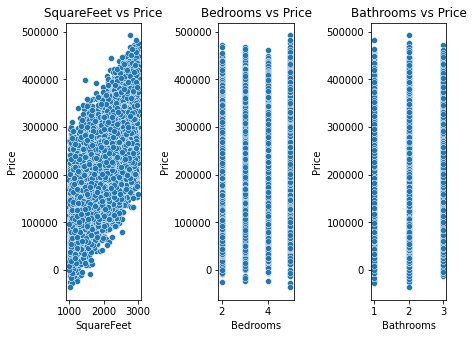

In [254]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6.4, 4.8))

sns.scatterplot(data=house_price_df, x='SquareFeet', y='Price', ax=ax1)
ax1.set_title("SquareFeet vs Price")

sns.scatterplot(data=house_price_df, x='Bedrooms', y='Price', ax=ax2)
ax2.set_title("Bedrooms vs Price")

sns.scatterplot(data=house_price_df, x='Bathrooms', y='Price', ax=ax3)
ax3.set_title("Bathrooms vs Price")

plt.tight_layout()
plt.show()


In the most left plot, we can see a somewhat linear relationship between square feet and price of the house. This may imply a linear model would be suitable. We can't really get much info from Bedrooms and Bathrooms though. 

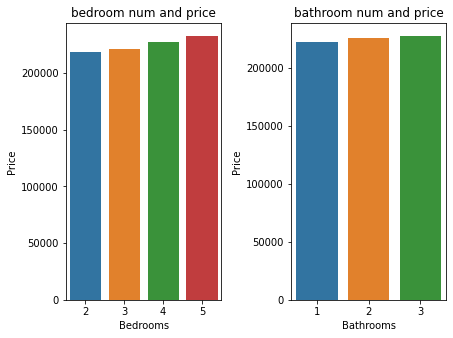

In [255]:
# We can do a bar chart for bedroom and bathrooms though
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.4, 4.8))

sns.barplot(data=house_price_df, x='Bedrooms', y='Price', ax=ax1, ci=False)
ax1.set_title('bedroom num and price')

sns.barplot(data=house_price_df, x='Bathrooms', y='Price', ax=ax2, ci=False)
ax2.set_title('bathroom num and price')

plt.tight_layout()
plt.show()

It really looks like theres very minimal correlation between number of bedrooms and bathrooms with house price.

# Model Building 

The data looks like it's in order. We know everything we need to know now. For this notebook, since I want to use it to practice, we will make 2 models:

1. Supervised Learning: Linear Regression Model
2. Unsupervised Learning: Hidden Layer Neural Network

For the first model, I want to try three approaches:

1. Normal Equation - Linear Algebra
2. Pure Numpy Implementation
3. sklearn

## Approach 1: Normal Equation

Based on our analysis above, we will only carry out this algorithm with a single input feature that is 'SquareFeet'.

First we need to define the normal equation:

A.T * A * x = A.T * y

note: In code we will not use * to represent matrix multiplcation because * actually represent element-wise operation, instead we will do np.matmul(a,b)

In [256]:
square_feet_column = house_price_df['SquareFeet'].array
y = house_price_df['Price'].array

# We build our X matrix as such
a = np.ones_like(square_feet_column).reshape(-1,1)
print(f"the shape of a at this instance: {a.shape}")

a = np.concatenate((a, square_feet_column.reshape(-1, 1)), axis=1)
print(f"the shape of a at this instance: {a.shape}")

the shape of a at this instance: (50000, 1)
the shape of a at this instance: (50000, 2)


In [257]:
# Let's print a few examples of x and y
print(a[:5])
print(y[:5])

[[   1 2126]
 [   1 2459]
 [   1 1860]
 [   1 2294]
 [   1 2130]]
<PandasArray>
[215355.28361820136, 195014.22162584803,  306891.0120763329,
 206786.78715332696,   272436.239065061]
Length: 5, dtype: float64


Ok now we have A and Y, we simply have to follow the algorithm. Next step is to solve the values of slope, w and constant, b

In [258]:
at_a = np.matmul(a.T, a)
print(f"AT * A has shape: {at_a.shape}")

at_y = np.matmul(a.T, y.reshape(-1,1))
print(f"AT * Y has shape: {at_y.shape}")

AT * A has shape: (2, 2)
AT * Y has shape: (2, 1)


Ok, all that's left to find our parameters is to row reduce. COOL FACT, we can define a function for row reducing via recursion! 

In [259]:
def row_echelon(A):
    """ Return Row Echelon Form of matrix A """

    # if matrix A has no columns or rows,
    # it is already in REF, so we return itself
    r, c = A.shape
    if r == 0 or c == 0:
        return A

    # we search for non-zero element in the first column
    for i in range(len(A)):
        if A[i,0] != 0:
            break
    else:
        # if all elements in the first column is zero,
        # we perform REF on matrix from second column
        B = row_echelon(A[:,1:])
        # and then add the first zero-column back
        return np.hstack([A[:,:1], B])

    # if non-zero element happens not in the first row,
    # we switch rows
    if i > 0:
        ith_row = A[i].copy()
        A[i] = A[0]
        A[0] = ith_row

    # we divide first row by first element in it
    A[0] = A[0] / A[0,0]
    # we subtract all subsequent rows with first row (it has 1 now as first element)
    # multiplied by the corresponding element in the first column
    A[1:] -= A[0] * A[1:,0:1]

    # we perform REF on matrix from second row, from second column
    B = row_echelon(A[1:,1:])

    # we add first row and first (zero) column, and return
    return np.vstack([A[:1], np.hstack([A[1:,:1], B]) ])

In [260]:
# Now we create an augmented matrix 
aug_matrix = np.concatenate((at_a, at_y), axis=1)
aug_matrix

array([[5.00000000e+04, 1.00318734e+08, 1.12413663e+10],
       [1.00318734e+08, 2.17837411e+11, 2.41992108e+13]])

In [261]:
rref = row_echelon(aug_matrix)
rref

array([[1.00000000e+00, 2.00637468e+03, 2.24827325e+05],
       [0.00000000e+00, 1.00000000e+00, 9.93221075e+01]])

Note that for the rref(augmented_matrix) column 1 represents b, our constant term and column 2 represents w, our slope

In [262]:
w = rref[1,2]
b = rref[0,2] - rref[0,1]*w

print(f"""Our parameters are as follows:
      Weight,w (slope): {w}
      Constant,b (intercept) {b}
      """)

Our parameters are as follows:
      Weight,w (slope): 99.32210752486009
      Constant,b (intercept) 25549.96344887372
      


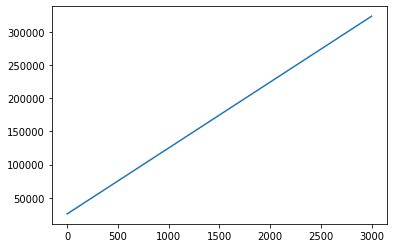

In [263]:
# Now we can plot the line 
x_test = np.arange(0, 3000)

y_pred = w*x_test + b

plt.plot(x_test, y_pred)

In [264]:
# To do: Calculate mean squared error

def mse(y_pred, y_actual, m):
    """
    Parameters:
    y_pred: array of predictions based of the created line of best fit
    y_actual: array of ground truth labels
    m: int, number of training examples

    Returns:
    mse: float, mean squared error value
    """

    mse = np.sum((y_pred - y_actual)**2) / (m)

    return mse

x_test = house_price_df['SquareFeet'].array
m = len(x_test)
y_pred_on_df = w*x_test + b
error = mse(y_pred_on_df, y, m=m)
print(f'The Mean Squared Error: {error}')
    

The Mean Squared Error: 2530128229.4533277


In [265]:
print(f"one example of y_actual: {y[1]}, but we predicted: {y_pred_on_df[1]}")

one example of y_actual: 195014.22162584803, but we predicted: 269783.02585250465


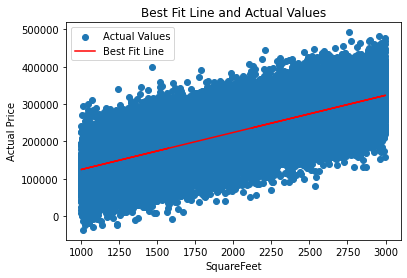

In [266]:
plt.scatter(x_test, y=y, label='Actual Values')
plt.plot(x_test, y_pred_on_df, color='red', label='Best Fit Line')

plt.title('Best Fit Line and Actual Values')
plt.xlabel('SquareFeet')
plt.ylabel('Actual Price')
plt.legend()
plt.show()

In [267]:
house_price_df.describe()

,SquareFeet,Bedrooms,Bathrooms,YearBuilt,Price
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2006.374680,3.498700,1.995420,1985.404420,224827.325151
std,575.513241,1.116326,0.815851,20.719377,76141.842966
min,1000.000000,2.000000,1.000000,1950.000000,-36588.165397
25%,1513.000000,3.000000,1.000000,1967.000000,169955.860225
50%,2007.000000,3.000000,2.000000,1985.000000,225052.141166
75%,2506.000000,4.000000,3.000000,2003.000000,279373.630052
max,2999.000000,5.000000,3.000000,2021.000000,492195.259972


So that's why our mean squared error is so high AHAHHA. I made a crucial mistake, let's do a 80/20 split on training to testing data when we carry out the next approach. Also, I will make sure to carry out feature scaling for both variables.

## Approach 2: Numpy w/ Gradient Descent

The first step would be to pre-process our data as such

In [268]:
house_price_df.head()

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
0,2126,4,1,Rural,1969,215355.283618
1,2459,3,2,Rural,1980,195014.221626
2,1860,2,1,Suburb,1970,306891.012076
3,2294,2,1,Urban,1996,206786.787153
4,2130,5,2,Suburb,2001,272436.239065


In [269]:
train_df = house_price_df[['SquareFeet', 'Price']][0:40000]
test_df = house_price_df[['SquareFeet', 'Price']][40000:50000]

In [270]:
x_train = train_df['SquareFeet'].array
y_train = train_df['Price'].array

Now we have to scale the data. For this I'll use z-normalization.

In [271]:
def z_normalize(data):
    """
    DOCUMENTATION
    """

    data_mean = np.mean(data)
    data_std = np.std(data)

    data_norm = (data - data_mean) / data_std

    return data_norm

# Normalize training data
x_train = z_normalize(x_train)
y_train = z_normalize(y_train)

Next, we'll implement the gradient descent algorithm to get optimal parameters.

In [272]:
def gradient_descent(x, y, w, b, epochs=10, alpha=0.01):
    """
    DOCUMENTATION
    """
    m = x_train.shape[0]
    cost_basket = []
    num_iter = []

    for i in range(epochs):
        y_pred = np.dot(w,x) + b

        # IMPLEMENT COST FUNCTION HERE
        cost = np.sum((y_pred - y)**2) / (2*m)


        dj_dw = np.sum((y_pred - y)*x)
        dj_db = np.sum((y_pred - y))

        dj_dw, dj_db = (1/m)*dj_dw, (1/m)*dj_db

        w = w - alpha*dj_dw
        b = b - alpha*dj_db

        if i%10 == 0:
            cost_basket.append(cost)
            num_iter.append(i)
            print(f"Epoch: {i} | Cost: {cost:.2e}")

    return w,b, cost_basket, num_iter


In [273]:
W, B, cb, ni = gradient_descent(x_train, y_train, w=100, b=26000, epochs=1000, alpha=0.001)

print(f"After 1000 iterations, optimal w is {W}, and optimal b is {B}")

Epoch: 0 | Cost: 3.38e+08
Epoch: 10 | Cost: 3.31e+08
Epoch: 20 | Cost: 3.25e+08
Epoch: 30 | Cost: 3.18e+08
Epoch: 40 | Cost: 3.12e+08
Epoch: 50 | Cost: 3.06e+08
Epoch: 60 | Cost: 3.00e+08
Epoch: 70 | Cost: 2.94e+08
Epoch: 80 | Cost: 2.88e+08
Epoch: 90 | Cost: 2.82e+08
Epoch: 100 | Cost: 2.77e+08
Epoch: 110 | Cost: 2.71e+08
Epoch: 120 | Cost: 2.66e+08
Epoch: 130 | Cost: 2.61e+08
Epoch: 140 | Cost: 2.55e+08
Epoch: 150 | Cost: 2.50e+08
Epoch: 160 | Cost: 2.45e+08
Epoch: 170 | Cost: 2.41e+08
Epoch: 180 | Cost: 2.36e+08
Epoch: 190 | Cost: 2.31e+08
Epoch: 200 | Cost: 2.27e+08
Epoch: 210 | Cost: 2.22e+08
Epoch: 220 | Cost: 2.18e+08
Epoch: 230 | Cost: 2.13e+08
Epoch: 240 | Cost: 2.09e+08
Epoch: 250 | Cost: 2.05e+08
Epoch: 260 | Cost: 2.01e+08
Epoch: 270 | Cost: 1.97e+08
Epoch: 280 | Cost: 1.93e+08


Epoch: 290 | Cost: 1.89e+08
Epoch: 300 | Cost: 1.85e+08
Epoch: 310 | Cost: 1.82e+08
Epoch: 320 | Cost: 1.78e+08
Epoch: 330 | Cost: 1.75e+08
Epoch: 340 | Cost: 1.71e+08
Epoch: 350 | Cost: 1.68e+08
Epoch: 360 | Cost: 1.64e+08
Epoch: 370 | Cost: 1.61e+08
Epoch: 380 | Cost: 1.58e+08
Epoch: 390 | Cost: 1.55e+08
Epoch: 400 | Cost: 1.52e+08
Epoch: 410 | Cost: 1.49e+08
Epoch: 420 | Cost: 1.46e+08
Epoch: 430 | Cost: 1.43e+08
Epoch: 440 | Cost: 1.40e+08
Epoch: 450 | Cost: 1.37e+08
Epoch: 460 | Cost: 1.35e+08
Epoch: 470 | Cost: 1.32e+08
Epoch: 480 | Cost: 1.29e+08
Epoch: 490 | Cost: 1.27e+08
Epoch: 500 | Cost: 1.24e+08
Epoch: 510 | Cost: 1.22e+08
Epoch: 520 | Cost: 1.19e+08
Epoch: 530 | Cost: 1.17e+08
Epoch: 540 | Cost: 1.15e+08
Epoch: 550 | Cost: 1.12e+08
Epoch: 560 | Cost: 1.10e+08
Epoch: 570 | Cost: 1.08e+08
Epoch: 580 | Cost: 1.06e+08
Epoch: 590 | Cost: 1.04e+08
Epoch: 600 | Cost: 1.02e+08
Epoch: 610 | Cost: 9.97e+07
Epoch: 620 | Cost: 9.78e+07
Epoch: 630 | Cost: 9.58e+07
Epoch: 640 | Cost: 9

As we can see, the gradient descent algorithm seems to be implemented well due to the constant decrement in cost function. In fact, I want to plot these values against iterations

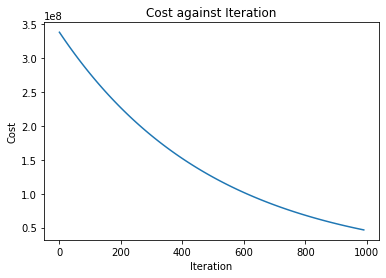

In [274]:
plt.plot(ni, cb)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost against Iteration")
plt.show()

This is roughly what we are looking for, a curve approach its local minimal (or in my case since I'm using a single variable, the local minima is the global minima!). Now let's plot the line based on parameters found by the gradient descent algorithm

In [275]:
yhat_train = z_normalize(W*x_train + B)

In [276]:
error_train = np.sum((yhat_train-y_train)**2) / (2*m)

print(f"MSE: {error_train}")

MSE: 0.19958851657949547


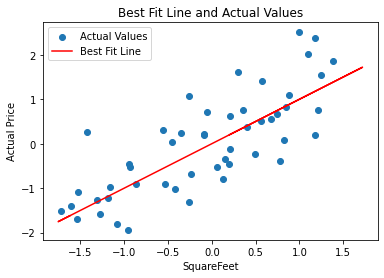

In [277]:
plt.scatter(x_train[:50], y=y_train[:50], label='Actual Values')
plt.plot(x_train, yhat_train, color='red', label='Best Fit Line')

plt.title('Best Fit Line and Actual Values')
plt.xlabel('SquareFeet')
plt.ylabel('Actual Price')
plt.legend()
plt.show()

Finally Let's test our model on the testing set we created earlier.

In [278]:
x_test = test_df['SquareFeet'].array
y_test = test_df['Price'].array

# Normalize these values
x_test = z_normalize(x_test)
y_test = z_normalize(y_test)

# Make Predictions
yhat_test = z_normalize(W * x_test + B)

# Find MSE
error = np.sum((yhat_test-y_test)**2) / (2*m)

print(f"The mean squared error is {error}")

The mean squared error is 0.049699636692381546


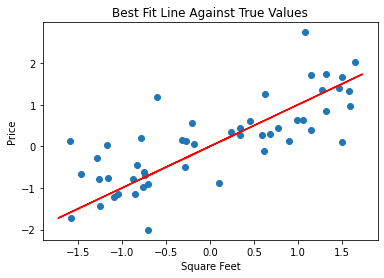

In [279]:
plt.scatter(x_test[:50], y_test[:50], label="Actual Values")
plt.plot(x_test, yhat_test, label='Best Fit Line', color='red')
plt.xlabel("Square Feet")
plt.ylabel("Price")
plt.title("Best Fit Line Against True Values")
plt.show()

In [280]:
# Print out comparison between training MSE and test MSE

print(f"The training set Error: {error_train} | The testing set Error: {error}")

The training set Error: 0.19958851657949547 | The testing set Error: 0.049699636692381546


So based on my results, we can see that the model did much better on the test set relative to the train set. Hence, this could be a sign that I'm underfitting the model, and so there's high bias in the model. What we can try moving forward is adding complexity to the model:

1. I can add more polynomial features
2. I can use the additional features that were available
3. I can add a regularization term in my gradient descent algorithm and play with lambda (most likely I'll find myself using smaller values of lambda to fix the bias)

### Improving The Model

I'm first going to try adding polynomial features, such that, my equation is in the form y = w_1.x + w_2.x**2 + b . Other processes will roughly look the same. From this point on though, I want to get a bit more practice with sklearn, so we will use that library instead.

In [281]:
X = np.c_[x_train, x_train**2, x_train**3, x_train**4, x_train**5, x_train**6, x_train**7]
X

array([[ 2.03691191e-01,  4.14901013e-02,  8.45116813e-03, ...,
         3.50639822e-04,  7.14222428e-05,  1.45480817e-05],
       [ 7.82746278e-01,  6.12691735e-01,  4.79582175e-01, ...,
         2.93836035e-01,  2.29999063e-01,  1.80030910e-01],
       [-2.58857317e-01,  6.70071105e-02, -1.73452808e-02, ...,
        -1.16225715e-03,  3.00858768e-04, -7.78794933e-05],
       ...,
       [ 4.76699145e-01,  2.27242075e-01,  1.08326103e-01, ...,
         2.46162483e-02,  1.17345445e-02,  5.59384733e-03],
       [ 5.84511203e-01,  3.41653346e-01,  1.99700209e-01, ...,
         6.82282445e-02,  3.98801733e-02,  2.33104081e-02],
       [-1.62215818e+00,  2.63139717e+00, -4.26854245e+00, ...,
        -1.12322305e+01,  1.82204546e+01, -2.95564595e+01]])

In [282]:
def poly_gradient_descent(X, y, w=0, b=0, iter=1000, alpha=0.01):
    m = X.shape[0]
    y = y.reshape(1, -1)

    for i in range(iter+1):
        yhat = np.dot(X, w) + b
        # Cost function
        cost = np.sum((yhat - y) ** 2) / (2 * m)

        # Get Derivatives
        dj_dw = np.sum((yhat - y) * X.T, axis=1)
        dj_db = np.sum(yhat - y)

        dj_dw, dj_db = (1 / m) * dj_dw, (1 / m) * dj_db

        # Update weights
        w = w - alpha*dj_dw
        b = b - alpha*dj_db

        if i % 10 == 0:
            print(f"Iteration {i} | Cost: {cost}")

    return w, b



In [283]:
w_init = np.array([0,0,0,0,0,0,0])

optimal_w, optimal_b = poly_gradient_descent(X, y_train, w=w_init)

Iteration 0 | Cost: 0.4999999999999999
Iteration 10 | Cost: 0.3155168092225444
Iteration 20 | Cost: 0.2949380974432678
Iteration 30 | Cost: 0.2808978634382719


Iteration 40 | Cost: 0.2699763155656777
Iteration 50 | Cost: 0.2614442615750969
Iteration 60 | Cost: 0.25476741870272174
Iteration 70 | Cost: 0.2495316456470966
Iteration 80 | Cost: 0.24541551327007752
Iteration 90 | Cost: 0.24216952655625165
Iteration 100 | Cost: 0.23960001216207089
Iteration 110 | Cost: 0.23755661717198062
Iteration 120 | Cost: 0.23592260920177868
Iteration 130 | Cost: 0.23460734978845293
Iteration 140 | Cost: 0.23354045387982492
Iteration 150 | Cost: 0.2326672574997645
Iteration 160 | Cost: 0.2319453004130076
Iteration 170 | Cost: 0.23134159634960505
Iteration 180 | Cost: 0.23083051433944138
Iteration 190 | Cost: 0.23039213426095675
Iteration 200 | Cost: 0.230010970391324
Iteration 210 | Cost: 0.22967498054802973
Iteration 220 | Cost: 0.22937479687759968
Iteration 230 | Cost: 0.22910312867321245
Iteration 240 | Cost: 0.22885429871765695
Iteration 250 | Cost: 0.2286238832716852
Iteration 260 | Cost: 0.2284084325188784
Iteration 270 | Cost: 0.2282052534699793
Iteratio

In [284]:
print(f"""
The Optimal Weights Are As follows:
W_1: {optimal_w[0]}
W_2: {optimal_w[1]}
W_3: {optimal_w[2]}
W_4: {optimal_w[3]}
W_5: {optimal_w[4]}
w_6: {optimal_w[5]}
w_7: {optimal_w[6]}

The Optimal Bias is b: {optimal_b}
""")


The Optimal Weights Are As follows:
W_1: 0.4931115977049638
W_2: 0.013427184038663196
W_3: 0.20135350421074374
W_4: 0.01000368914134294
W_5: 0.021504093262484845
w_6: -0.006044940022246106
w_7: -0.022732307025509987

The Optimal Bias is b: -0.008589587070381969



I'd love to plot this but plotting something with 3 variables entails plotting it in 4D which we know is not possible (at the moment). We can however proceed with measuring it's accuracy

In [285]:
# TRAIN ERROR
YHAT_TRAIN = z_normalize(np.matmul(X,optimal_w) + optimal_b)
ERROR_TRAIN = np.sum((YHAT_TRAIN-y_train)**2) / (2*m)


# TEST ERROR
X_TEST = np.c_[x_test, x_test**2, x_test**3, x_test**4, x_test**5, x_test**6, x_test**7]
YHAT_TEST = z_normalize(np.matmul(X_TEST,optimal_w) + optimal_b)
ERROR_TEST = np.sum((YHAT_TEST-y_test)**2) / (2*m)

print(f"Train Set Error: {ERROR_TRAIN} | Test Set Error: {ERROR_TEST}")

Train Set Error: 0.20246337459407063 | Test Set Error: 0.050522222555939106


Even after increasing the polynomial degree to 7, our model is still underfitting. The next step that I want to pursue is to use other features in the housing data, we'll see what happens then. However, moving forward, instead of coding the algorithm manually, I will instead just use the sklearn library to be more familiar with it.

## Approach 3: Sklearn Linear Regression Implementation

In [286]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

In [295]:
house_price_df = pd.read_csv('housing_price_dataset.csv')
house_price_df.head()

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
0,2126,4,1,Rural,1969,215355.283618
1,2459,3,2,Rural,1980,195014.221626
2,1860,2,1,Suburb,1970,306891.012076
3,2294,2,1,Urban,1996,206786.787153
4,2130,5,2,Suburb,2001,272436.239065


In [296]:
# We're going to do some feature engineering, we're gonna find the age of the house relative to present day
house_price_df['Age'] = 2020 - house_price_df['YearBuilt']
house_price_df.head()

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price,Age
0,2126,4,1,Rural,1969,215355.283618,51
1,2459,3,2,Rural,1980,195014.221626,40
2,1860,2,1,Suburb,1970,306891.012076,50
3,2294,2,1,Urban,1996,206786.787153,24
4,2130,5,2,Suburb,2001,272436.239065,19


In [302]:
important_columns = ['SquareFeet', 'Bedrooms', "Bathrooms", "Age", "Price"]
new_df = house_price_df[important_columns]

train_data = new_df[:40000]
test_data = new_df[40000:]

x_train = train_data[['SquareFeet', 'Bedrooms', "Bathrooms", "Age"]]
y_train = train_data['Price']

x_test = test_data[['SquareFeet', 'Bedrooms', "Bathrooms", "Age"]]
y_test = test_data['Price']

In [305]:
# Now we initialize the scaler and the linear model
scaler = StandardScaler()
model = SGDRegressor(max_iter=1000)

In [306]:
# Now we normalize the data
x_train_norm = scaler.fit_transform(x_train)
x_train_norm

array([[ 0.20369119,  0.44810228, -1.21671652,  0.79379014],
       [ 0.78274628, -0.44837122,  0.00808368,  0.26241081],
       [-0.25885732, -1.34484471, -1.21671652,  0.74548293],
       ...,
       [ 0.47669914,  1.34457577,  1.23288388, -1.66987766],
       [ 0.5845112 ,  1.34457577,  1.23288388,  0.35902524],
       [-1.62215818,  1.34457577,  1.23288388, -0.12404688]])

In [307]:
# Now we fit the model
model.fit(x_train_norm, y_train)

SGDRegressor()

In [308]:
optimal_w = model.coef_
optimal_b = model.intercept_

print(f"""
Optimal W: {optimal_w}
Optimal b: {optimal_b}
""")


Optimal W: [56498.14259844  5378.33302009  2457.40491883  -629.77141029]
Optimal b: [225411.45180066]



In [309]:
# Don't forget to scale x_test
x_test_norm = scaler.fit_transform(x_test)

In [310]:
y_pred = model.predict(x_test_norm)

In [313]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(y_test, y_pred)

print(f"The mean squared error for the model is: {error}")

The mean squared error for the model is: 2505466877.9229937


The error is way too high. It looks like a linear model just isn't suited for this data type! Best thing to do moving forward in my opinion, is to try other approaches like decision trees or deep neural networks